## Replacing gather_nd

#### Lift batch_gather into our disparity gather

Plan:
- we are using batch gather instead of gather_nd

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from timeit import default_timer as timer

In [2]:
from test import *
home = Path.home() / 'deeval'
import sys; sys.path.append(str(home))
from evaluate import show_row
import emfnet.dataset_wheel_render as ds

import sys; sys.path.append('/home/marek/emfnet')
from dense_image_warp import dense_image_warp
from bilinear_sampler import simple_sampler, linear_sampler, bilinear_sampler


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
ds.BATCH, ds.cnt, ds.padd = 1, 1, 1
ds.H = 2056
dataset = ds.get_dataset(str(home / ds.folder), 'valid', fast_start=True, right_disp=True)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
sess = tf.Session()

In [5]:
sess.run(dataset.initializer)
limg, rimg, ldisp, rdisp = map(lambda x: x[:,256:512,...], sess.run(dataset.get_next()))

Left; Right


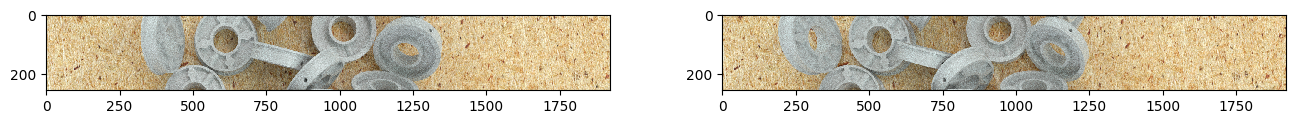

AttributeError: 'Tensor' object has no attribute 'numpy'

In [9]:
def samp(ldisp, rimg):
#     return linear_sampler(rimg, ldisp)
    return dense_image_warp(rimg, tf.concat([tf.zeros_like(ldisp), -ldisp], axis=3))

EPSILON = 0.3
print('Left; Right'); show_row(limg[0], rimg[0])
print('Warp Left; Warp Right'); show_row(samp(ldisp, rimg)[0], samp(-rdisp, limg)[0])
print('Warp LDisp; Warp RDisp'); show_row(samp(ldisp, rdisp)[0,...,0], samp(-rdisp,ldisp)[0,...,0])
occl = tf.abs(ldisp - samp(ldisp, rdisp))[0,...,0].numpy()
nlimg = limg[0].numpy()
nlimg[occl > EPSILON] = (0, 0, 0)
occr = tf.abs(rdisp - samp(-rdisp, ldisp))[0,...,0].numpy()
nrimg = rimg[0].numpy()
nrimg[occr > EPSILON] = (0, 0, 0)
print('Occlusions Left; Occlusions Right'); show_row(nlimg, nrimg)

In [ ]:
rldisp = np.round(ldisp)
show_row(limg[0,...,0], rimg[0], rldisp[0,...,0])

In [ ]:
sess.run(tf.batch_gather(tf.constant([[[1,1],[2,2],[3,3],[4,4],[5,5],[6,6]]]), tf.constant([[0,0,3,3,4,4,2]])))

In [ ]:
td = tf.cast(tf.convert_to_tensor(rldisp), tf.int32)
tr = tf.convert_to_tensor(limg)
shape = rldisp.shape
shape

In [ ]:
# from emfnet.bilinear_sampler import linear_sampler
# linear_sampler._get_grid_array(shape[0], shape[1], shape[2], tf.)

In [ ]:
rtd = (td + tf.cast(tf.reshape(tf.range(tf.constant(1920)), (1920, 1)), td.dtype))[...,0]
rtr = tr
rtd.shape, rtr.shape

In [ ]:
start = timer()
warped = sess.run(tf.batch_gather(rtr, rtd))
print(rtr.shape, rtd.shape, warped.shape)
print(f'New method time: {timer()-start}')
show_row(warped[0], dpi=30)

In [ ]:
start2 = timer()
warped_ours = sess.run(simple_sampler(tr, tf.cast(td, tf.float32), out='EDGE'))
print(f'Old metchod time: {timer()-start2}')
print(rtr.shape, rtd.shape, warped.shape)
show_row(warped_ours[0], dpi=30)

In [ ]:
dtype = tf.float32
def _get_grid_array(N, H, W, h, w):
    N_i = tf.range(N)
    H_i = tf.range(h+1, h+H+1)
    W_i = tf.range(w+1, w+W+1)
    n, h, w, = tf.meshgrid(N_i, H_i, W_i, indexing='ij')
    n = tf.expand_dims(n, axis=3) # [N, H, W, 1]
    h = tf.expand_dims(h, axis=3) # [N, H, W, 1]
    w = tf.expand_dims(w, axis=3) # [N, H, W, 1]
    n = tf.cast(n, dtype) # [N, H, W, 1]
    h = tf.cast(h, dtype) # [N, H, W, 1]
    w = tf.cast(w, dtype) # [N, H, W, 1]
    return n, h, w

N, H, W, h, w = 3, 256, 1920, 0, 0
n,h,w = sess.run([_get_grid_array(N,H,W,h,w)])[0]
print(n.shape, h.shape, w.shape)
n[0,...], h[0,...], w[0,...]

In [ ]:
import tensorflow as tf
tf.Session().run(tf.clip_by_value(1000, 0, 4))